<a href="https://colab.research.google.com/github/nielsrolf/VariationalAnnealingAutoEncoder/blob/master/VariationalAnnealingAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Annealing Autoencoder

Idea: Using an autoencoder with limited encoding space due to tanh activations, we can add GaussNoise to limit the mutual information from the encoding with the input.



## As a generative model
The target is to train an autoencoder as a generative model. Naturally, autoencoders are mode covering algorithms, which limits their performance as generative models.
For generation, we want mode seeking models because we usually care less about the ability to encode every possible sample of the true distibution. Instead, we would like to assure that every generated model has a high likelihood by $P_{real}$.

The difference between mode seeking and mode covering behavior can be explained nicely by this graphic taken from [this article](https://aiden.nibali.org/blog/2016-12-21-gan-objective/):

![Mode seeking vs mode covering](https://aiden.nibali.org/img/bimodal.svg)

With high noise, we limit the capacity of the autoencoder => mode covering
- with infinite variance noise, the optimal solution would be to always predict the same (mean if we optimize MSE)
- with zero noise, the optimal solution is to perfectly encode the samples (assuming the capacity of the encoding space is sufficient)
- for intermediate states, the loss function and need to compress will determine a compromise
    - we want to be mode seeking, so we should use a loss function that does not put a penalty on huge outliers

We increase the capacity by annealing during training => details are learned later during training


## Information Bottleneck
In general, this is a way to use neural networks to explicily train to optimize the IB objective. Compare Information Dropout: multiplicative noise

## Clustering
We want to find clusters in which smooth transitions exist (between all images of a certain digit this is the case, between different clusters this may not be the case).
Idea: conditional VAAE - will it generate better?
Add to the latent space a softmax layer for clusters



In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import numpy as np
from matplotlib import pyplot as plt

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


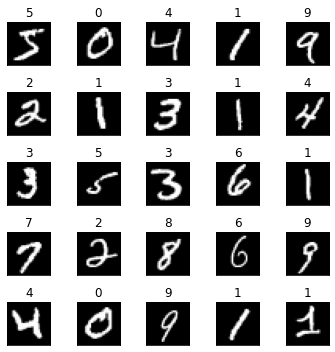

In [0]:
def visualize_digits(X, Y=None):
    X = (X+1)/2
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(cols,rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            if Y.ndim==2:
                y = np.argmax(Y[i])
            else:
                y = Y[i]
            ax.set_title(y)
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        ax.imshow(x, cmap="gray")
    plt.tight_layout()
    plt.show()


visualize_digits(x_train[:25], y_train[:25])

Now we will build an autoencoder with limited capacity in the bottleneck, and add gaussian noise with decreasing variance onto the encoding layer.

$$
I(X, e) = H(e) - H(e|X) \\
\leq H(\mathcal{U}_{[-1, 1]^D})  - H(e|X)
$$





In [0]:
x_train.shape

(60000, 28, 28, 1)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, ZeroPadding2D, Flatten, Reshape, BatchNormalization, GaussianNoise, UpSampling2D

def create_model(D=128, optimizer=tf.optimizers.Adam(), lossfunction=tf.keras.losses.MeanAbsoluteError()):
    input_imgs = Input([28, 28, 1], dtype=tf.float32)
    noise_std = Input([1], dtype=tf.float32)
    X = Conv2D(32, kernel_size=3, strides=2, padding="same")(input_imgs)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(64, kernel_size=3, strides=2, padding="same")(X)
    X = ZeroPadding2D(padding=((0,1),(0,1)))(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(128, kernel_size=3, strides=2, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(256, kernel_size=3, strides=1, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Flatten()(X)
    encoded = Dense(D, activation='tanh')(X)
    noise = GaussianNoise(1)(encoded*0)*noise_std
    encoded = encoded + noise

    decoder_input = Input(shape=[D])
    X = Dense(128 * 7 * 7, activation="relu")(decoder_input)
    X = Reshape((7, 7, 128))(X)
    X = UpSampling2D()(X)
    X = Conv2D(128, kernel_size=3, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = tf.keras.activations.relu(X)
    X = UpSampling2D()(X)
    X = Conv2D(64, kernel_size=3, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = tf.keras.activations.relu(X)
    X = Conv2D(1, kernel_size=3, padding="same")(X)
    reconstruction = tf.keras.activations.tanh(X)

    encoder = Model(inputs=[input_imgs, noise_std], outputs=encoded)
    decoder = Model(inputs=decoder_input, outputs=reconstruction)

    input_imgs = Input([28, 28, 1], dtype=tf.float32)
    noise_std = Input([1], dtype=tf.float32)
    encoded = encoder([input_imgs, noise_std])
    decoded = decoder(encoded)
    autoencoder = Model(inputs=[input_imgs, noise_std], outputs=decoded)

    encoder.summary()
    decoder.summary()
    autoencoder.summary()

    autoencoder.compile(loss=lossfunction, optimizer=optimizer)
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_model()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 14, 14, 32)   320         input_16[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 7, 7, 64)     18496       leaky_re_lu_12[0][0]             
____________________________________________________________________________________________

In [0]:
def permute(x):
    """Permutes a list of arrays, e.g. X, y with the same permutation
    """
    perm = np.random.permutation(len(x))
    return x[perm]

def batches(x, std, batch_size=128):
    x = permute(x)
    std = np.ones([batch_size, 1])*std
    for i in range(len(x)//batch_size):
        imgs = x[i*batch_size:(i+1)*batch_size]
        yield [imgs, std], imgs
        
def noargs(function):
    def wrapped(*args, **kwargs):
        return function()
    return wrapped

@noargs
def generate():
    print("Generated")
    z = np.random.uniform(low=-1, high=1, size=[4, 128])
    imgs = decoder.predict(z)
    visualize_digits(imgs)


def interpolate(x1, x2):
    print("Interpolation")
    encoded = encoder.predict([np.array([x1, x2]), np.zeros([2, 1])])
    e0 = encoded[0][None,...]
    e01 = encoded[1][None,...] - e0
    z_interpolate = e0 + np.arange(0, 1.00000001, 1/15)[...,None]*e01
    x_interpolated = decoder.predict(z_interpolate)
    visualize_digits(x_interpolated)

@noargs
def show_samples():
    re = autoencoder.predict([x_test[:9], np.zeros([9, 1])])
    visualize_digits(re, y_test[:9])
    visualize_digits(x_test[:9], y_test[:9])

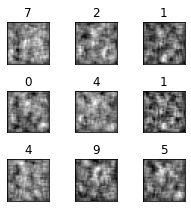

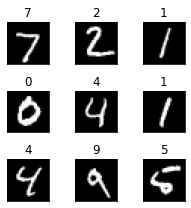

In [0]:
show_samples()

In [0]:
!pip install git+https://github.com/nielsrolf/scheduler.git

  Cloning https://github.com/nielsrolf/scheduler.git to /tmp/pip-req-build-c7b2z069
  Running command git clone -q https://github.com/nielsrolf/scheduler.git /tmp/pip-req-build-c7b2z069
  Created wheel for scheduler: filename=scheduler-0.1-cp36-none-any.whl size=8395 sha256=74f9a2863423afb4fea4620f31c9363be9bf4903663c9f0ec2268e929284c9c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-73ciaho3/wheels/6f/3a/9a/93ec95d6a39a035b5d0952d4cd28c8fad7f9fb02e63a366882
Successfully built scheduler


468/468 [==============================] - 10s 22ms/step - loss: 0.1170


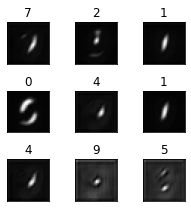

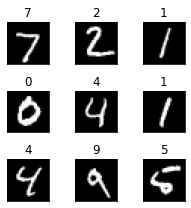

Interpolation


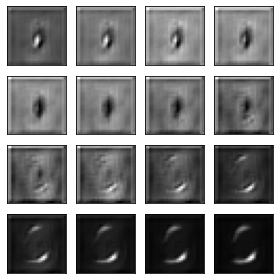

Generated


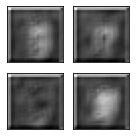

468/468 [==============================] - 10s 22ms/step - loss: 0.0909


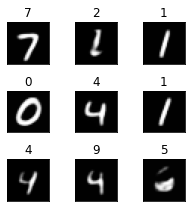

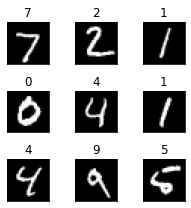

Interpolation


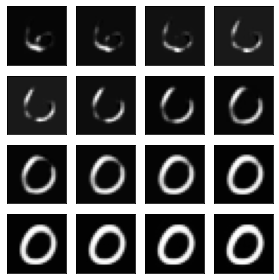

Generated


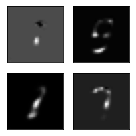

468/468 [==============================] - 10s 22ms/step - loss: 0.0710


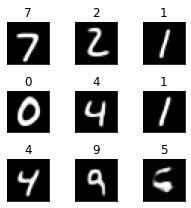

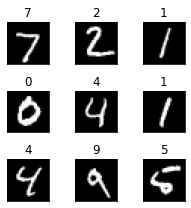

Interpolation


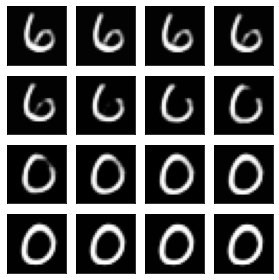

Generated


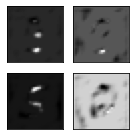

468/468 [==============================] - 10s 22ms/step - loss: 0.0570


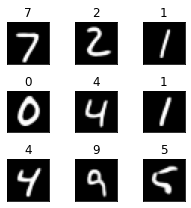

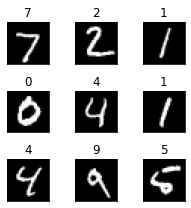

Interpolation


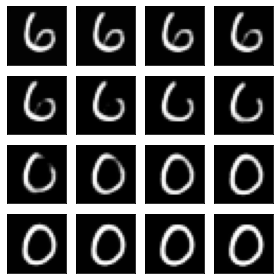

Generated


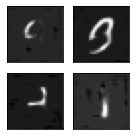

468/468 [==============================] - 10s 22ms/step - loss: 0.0471


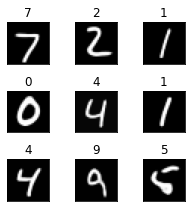

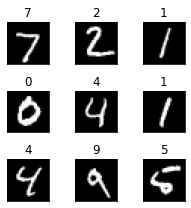

Interpolation


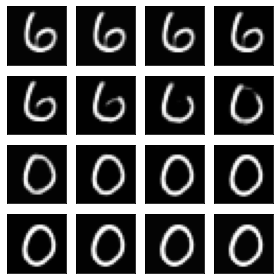

Generated


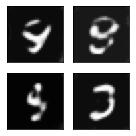

468/468 [==============================] - 10s 22ms/step - loss: 0.0403


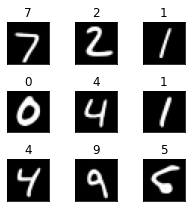

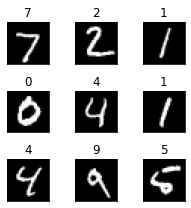

Interpolation


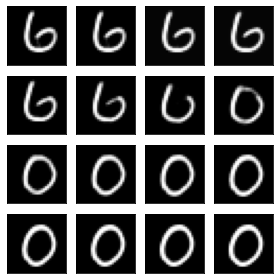

Generated


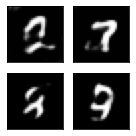

468/468 [==============================] - 10s 22ms/step - loss: 0.0352


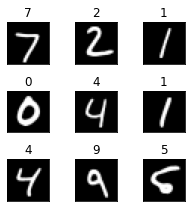

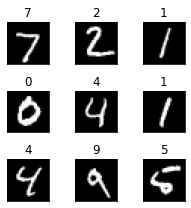

Interpolation


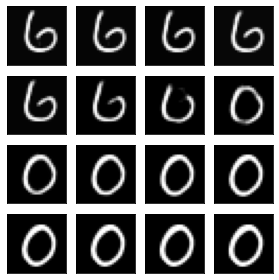

Generated


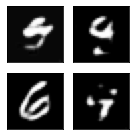

468/468 [==============================] - 10s 22ms/step - loss: 0.0312


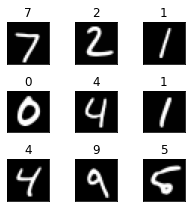

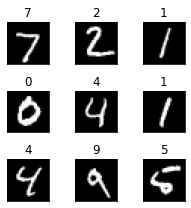

Interpolation


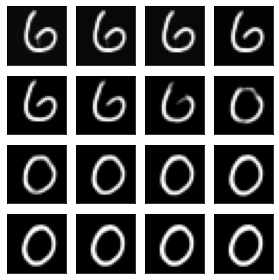

Generated


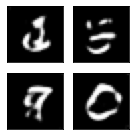

468/468 [==============================] - 10s 22ms/step - loss: 0.0282


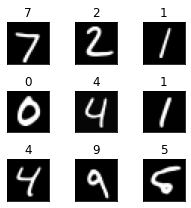

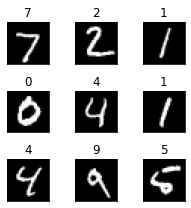

Interpolation


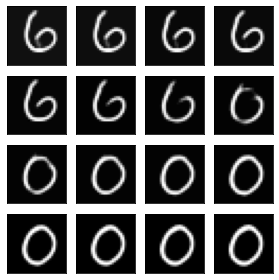

Generated


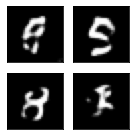

468/468 [==============================] - 10s 22ms/step - loss: 0.0259


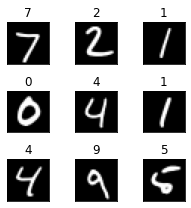

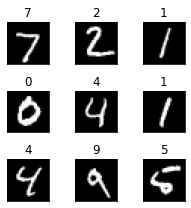

Interpolation


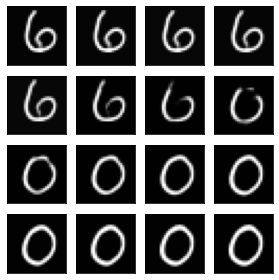

Generated


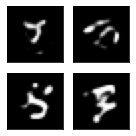

468/468 [==============================] - 10s 22ms/step - loss: 0.0243


In [0]:
from scheduler import Schedule

training = Schedule().every(1).do(
        lambda step, d: autoencoder.fit(batches(x_train, 120/(step*2+15)))
    ).every(10, 1).do(
        show_samples
    ).every(10, 1).do(
        lambda i, d: interpolate(x_test[100], x_test[101])
    ).every(10, 1).do(
        generate
    )
    
training.forNext(100).execute()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 14, 14, 32)   320         input_21[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 7, 7, 64)     18496       leaky_re_lu_16[0][0]             
___________________________________________________________________________________________

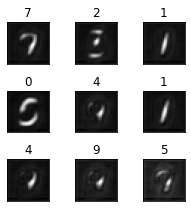

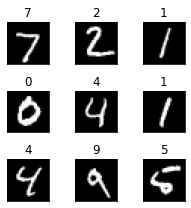

Interpolation


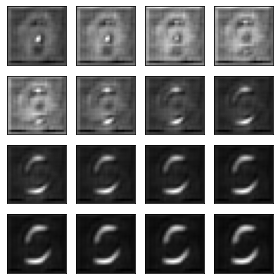

Generated


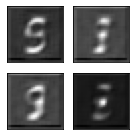

468/468 [==============================] - 11s 23ms/step - loss: 0.0906


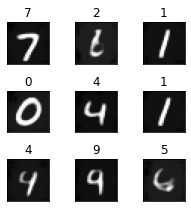

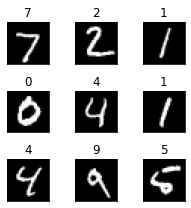

Interpolation


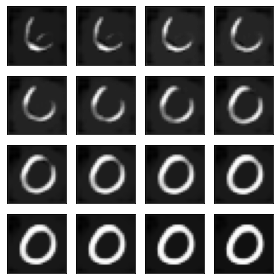

Generated


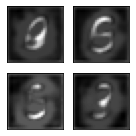

468/468 [==============================] - 11s 24ms/step - loss: 0.0711


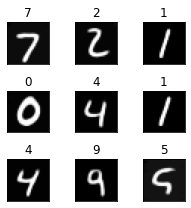

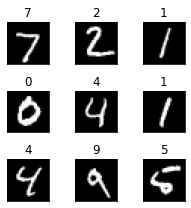

Interpolation


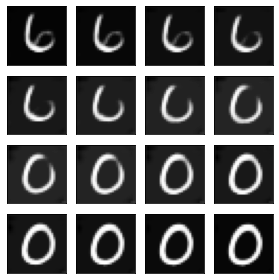

Generated


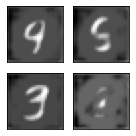

468/468 [==============================] - 11s 24ms/step - loss: 0.0572


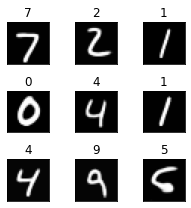

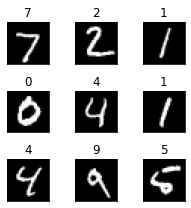

Interpolation


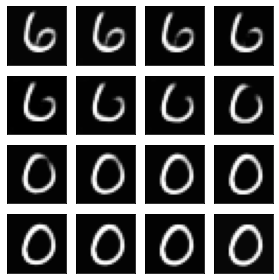

Generated


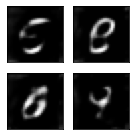

468/468 [==============================] - 11s 24ms/step - loss: 0.0475


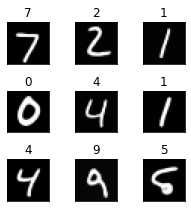

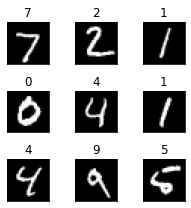

Interpolation


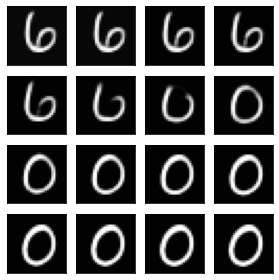

Generated


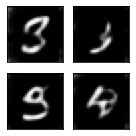

468/468 [==============================] - 11s 24ms/step - loss: 0.0408


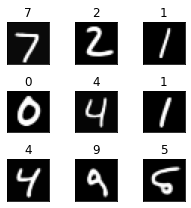

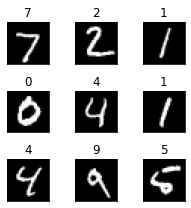

Interpolation


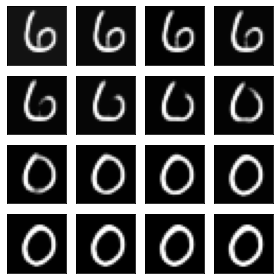

Generated


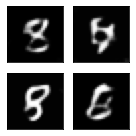

468/468 [==============================] - 11s 23ms/step - loss: 0.0358


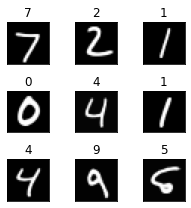

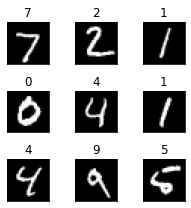

Interpolation


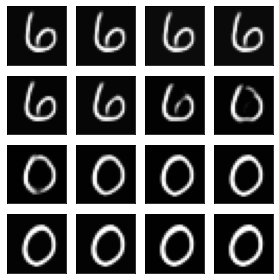

Generated


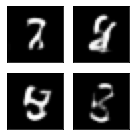

468/468 [==============================] - 11s 24ms/step - loss: 0.0318


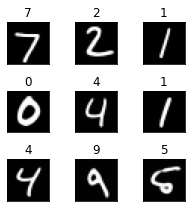

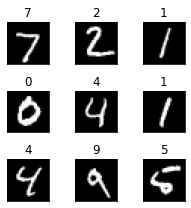

Interpolation


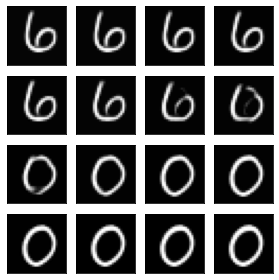

Generated


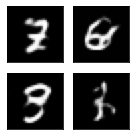

468/468 [==============================] - 11s 23ms/step - loss: 0.0288


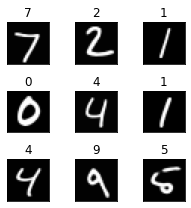

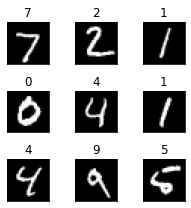

Interpolation


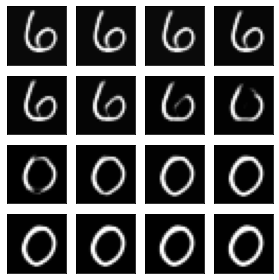

Generated


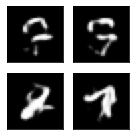

468/468 [==============================] - 11s 23ms/step - loss: 0.0265


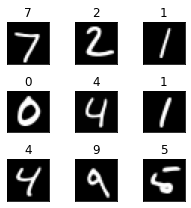

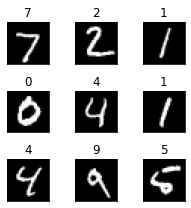

Interpolation


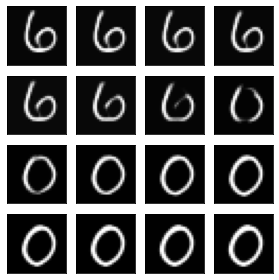

Generated


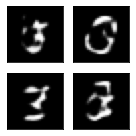

468/468 [==============================] - 11s 23ms/step - loss: 0.0249


In [0]:
encoder, decoder, autoencoder = create_model(optimizer=tf.optimizers.RMSprop())

training = Schedule().every(1).do(
    lambda step, d: autoencoder.fit(batches(x_train, 120/(step*2+15)))
).every(10, 1).do(
    show_samples
).every(10, 1).do(
    lambda i, d: interpolate(x_test[100], x_test[101])
).every(10, 1).do(
    generate
)
    
training.forNext(100).execute()

## Clustering

In [0]:
from tensorflow.keras.layers import concatenate

def create_clustering_ae(D=32, C=10, optimizer=tf.optimizers.RMSprop(), lossfunction=tf.keras.losses.MeanAbsoluteError()):
    input_imgs = Input([28, 28, 1], dtype=tf.float32)
    noise_std = Input([1], dtype=tf.float32)
    X = Conv2D(32, kernel_size=3, strides=2, padding="same")(input_imgs)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(64, kernel_size=3, strides=2, padding="same")(X)
    X = ZeroPadding2D(padding=((0,1),(0,1)))(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(128, kernel_size=3, strides=2, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Conv2D(256, kernel_size=3, strides=1, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = LeakyReLU(alpha=0.2)(X)
    X = Flatten()(X)
    encoded = Dense(D, activation='tanh')(X)
    clusters = Dense(C)(X)
    clusters = tf.keras.activations.softmax(clusters)
    noise = GaussianNoise(0.1)(clusters*0)
    clusters = clusters + noise
    noise = GaussianNoise(1)(encoded*0)*noise_std
    encoded = encoded + noise

    decoder_input = Input(shape=[D])
    cluster_input = Input(shape=[C])
    X = concatenate([decoder_input, cluster_input])
    X = Dense(128 * 7 * 7, activation="relu")(X)
    X = Reshape((7, 7, 128))(X)
    X = UpSampling2D()(X)
    X = Conv2D(128, kernel_size=3, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = tf.keras.activations.relu(X)
    X = UpSampling2D()(X)
    X = Conv2D(64, kernel_size=3, padding="same")(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = tf.keras.activations.relu(X)
    X = Conv2D(1, kernel_size=3, padding="same")(X)
    reconstruction = tf.keras.activations.tanh(X)

    encoder = Model(inputs=[input_imgs, noise_std], outputs=[encoded, clusters])
    decoder = Model(inputs=[decoder_input, cluster_input], outputs=reconstruction)

    input_imgs = Input([28, 28, 1], dtype=tf.float32)
    noise_std = Input([1], dtype=tf.float32)
    encoded, clusters = encoder([input_imgs, noise_std])
    decoded = decoder([encoded, clusters])
    autoencoder = Model(inputs=[input_imgs, noise_std], outputs=decoded)

    encoder.summary()
    decoder.summary()
    autoencoder.summary()

    autoencoder.compile(loss=lossfunction, optimizer=optimizer)
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = create_clustering_ae()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 14, 14, 32)   320         input_57[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_48 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 7, 7, 64)     18496       leaky_re_lu_48[0][0]             
___________________________________________________________________________________________

468/468 [==============================] - 11s 23ms/step - loss: 0.1410
[0.03 0.79 0.   0.02 0.   0.05 0.   0.   0.05 0.07]
[0.43 0.   0.   0.   0.   0.02 0.   0.   0.   0.54]
[0.55 0.07 0.01 0.02 0.   0.09 0.   0.01 0.08 0.18]
[0.09 0.6  0.03 0.03 0.   0.   0.   0.   0.11 0.13]
[0.09 0.   0.   0.3  0.   0.07 0.   0.   0.   0.54]
[0.1  0.55 0.03 0.04 0.   0.03 0.   0.   0.04 0.22]
[0.08 0.05 0.01 0.   0.   0.65 0.   0.   0.   0.21]
[0.11 0.01 0.   0.77 0.   0.01 0.   0.   0.01 0.1 ]
[0.22 0.15 0.02 0.07 0.   0.08 0.   0.   0.35 0.11]
[0.07 0.01 0.   0.73 0.   0.04 0.   0.   0.02 0.13]
Generate


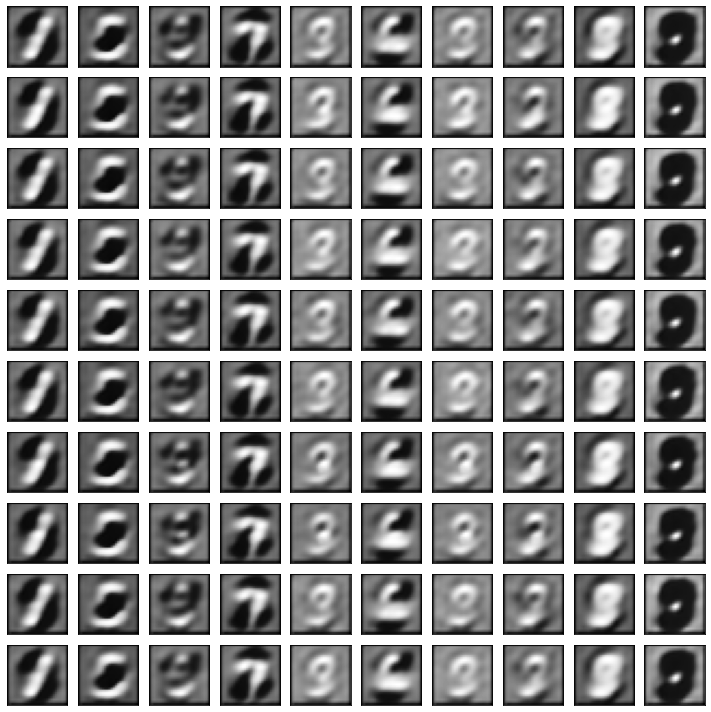

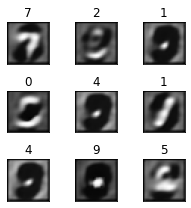

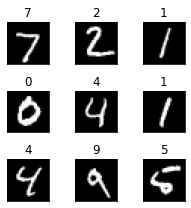

468/468 [==============================] - 11s 23ms/step - loss: 0.0902
[0.01 0.41 0.05 0.03 0.   0.29 0.   0.06 0.08 0.08]
[0.65 0.   0.01 0.01 0.   0.01 0.   0.04 0.01 0.27]
[0.22 0.01 0.05 0.03 0.   0.09 0.   0.49 0.04 0.06]
[0.08 0.03 0.55 0.04 0.   0.03 0.   0.1  0.09 0.09]
[0.09 0.01 0.04 0.38 0.   0.16 0.   0.09 0.05 0.19]
[0.07 0.12 0.23 0.08 0.   0.11 0.   0.03 0.2  0.17]
[0.04 0.03 0.02 0.02 0.   0.74 0.   0.04 0.02 0.09]
[0.17 0.02 0.03 0.53 0.   0.01 0.   0.11 0.02 0.11]
[0.12 0.02 0.14 0.05 0.   0.05 0.   0.06 0.5  0.06]
[0.08 0.03 0.08 0.44 0.   0.06 0.   0.05 0.14 0.11]
Generate


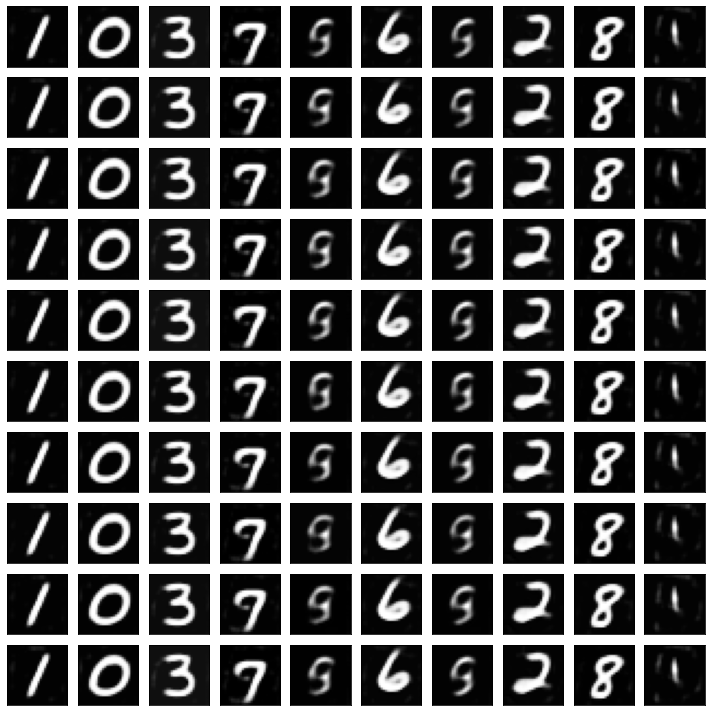

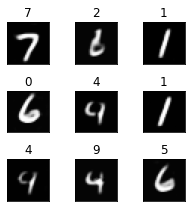

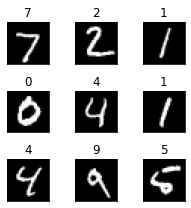

468/468 [==============================] - 11s 23ms/step - loss: 0.0826
[0.01 0.64 0.05 0.02 0.   0.08 0.   0.07 0.07 0.06]
[0.56 0.   0.01 0.01 0.   0.01 0.   0.05 0.01 0.35]
[0.2  0.03 0.14 0.04 0.   0.07 0.   0.4  0.04 0.09]
[0.08 0.03 0.56 0.03 0.   0.02 0.   0.1  0.06 0.11]
[0.11 0.01 0.04 0.35 0.   0.15 0.   0.06 0.04 0.25]
[0.08 0.16 0.25 0.07 0.   0.06 0.   0.05 0.17 0.16]
[0.05 0.11 0.04 0.02 0.   0.57 0.   0.04 0.03 0.15]
[0.14 0.04 0.02 0.54 0.   0.01 0.   0.14 0.01 0.1 ]
[0.11 0.03 0.23 0.05 0.   0.04 0.   0.06 0.39 0.08]
[0.09 0.04 0.1  0.42 0.   0.05 0.   0.05 0.12 0.14]
Generate


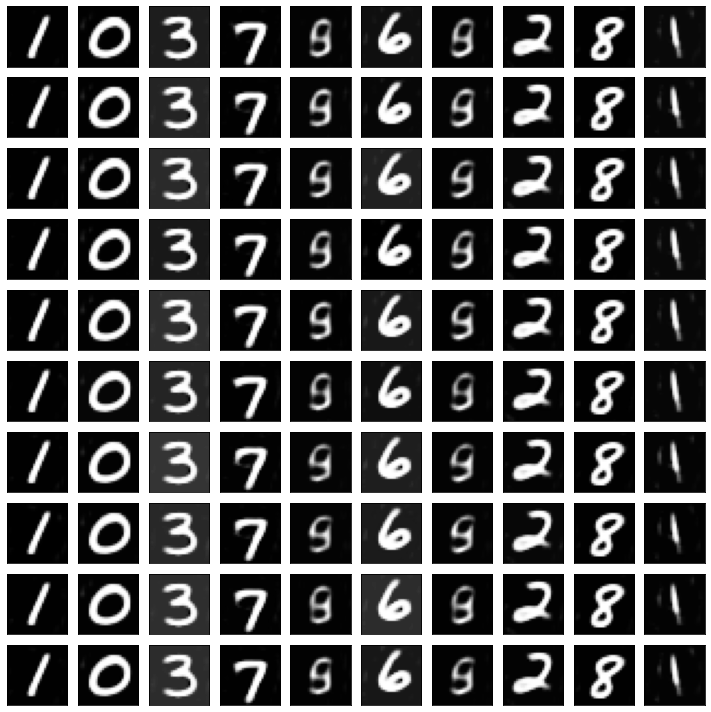

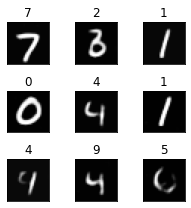

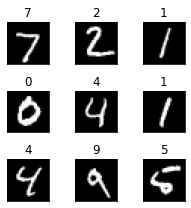

468/468 [==============================] - 11s 23ms/step - loss: 0.0776
[0.01 0.53 0.05 0.02 0.   0.11 0.   0.12 0.08 0.09]
[0.61 0.   0.   0.01 0.   0.   0.   0.04 0.01 0.33]
[0.23 0.02 0.09 0.03 0.   0.07 0.   0.41 0.04 0.11]
[0.12 0.03 0.45 0.03 0.   0.03 0.   0.1  0.1  0.14]
[0.11 0.02 0.02 0.36 0.   0.16 0.   0.08 0.05 0.2 ]
[0.11 0.15 0.19 0.05 0.   0.06 0.   0.06 0.21 0.17]
[0.06 0.09 0.04 0.02 0.   0.58 0.   0.05 0.03 0.14]
[0.17 0.04 0.01 0.51 0.   0.01 0.   0.14 0.01 0.11]
[0.13 0.02 0.17 0.05 0.   0.04 0.   0.06 0.44 0.09]
[0.09 0.04 0.06 0.41 0.   0.05 0.   0.06 0.15 0.14]
Generate


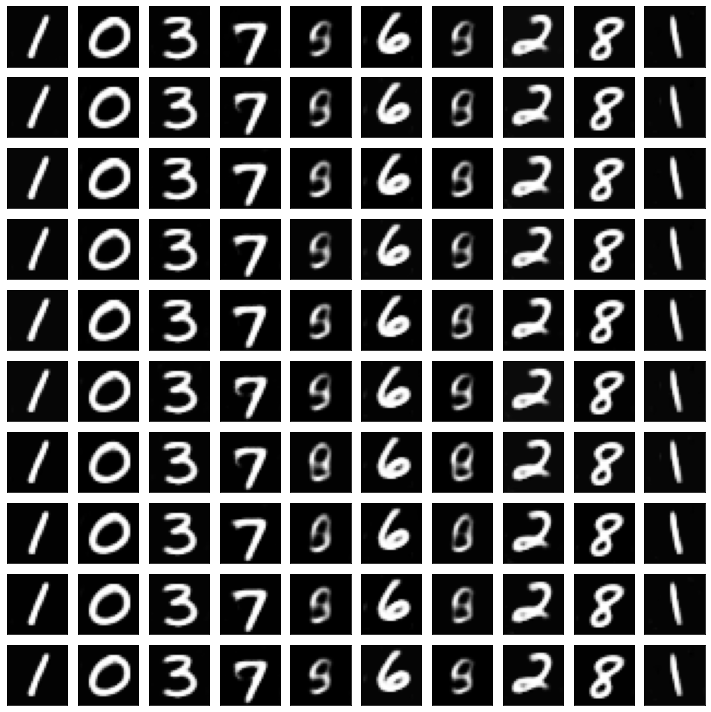

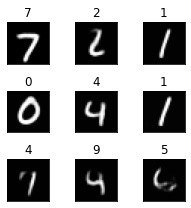

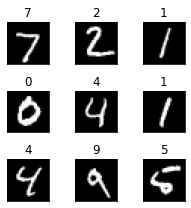

468/468 [==============================] - 11s 23ms/step - loss: 0.0737
[0.01 0.63 0.06 0.01 0.   0.08 0.   0.09 0.07 0.05]
[0.6  0.   0.   0.01 0.   0.01 0.   0.05 0.01 0.32]
[0.19 0.03 0.12 0.03 0.   0.07 0.   0.44 0.04 0.08]
[0.09 0.03 0.55 0.03 0.   0.02 0.   0.09 0.08 0.11]
[0.1  0.02 0.02 0.43 0.   0.13 0.   0.07 0.04 0.19]
[0.09 0.2  0.24 0.04 0.   0.05 0.   0.06 0.2  0.13]
[0.05 0.11 0.05 0.01 0.   0.58 0.   0.04 0.05 0.11]
[0.15 0.05 0.01 0.54 0.   0.   0.   0.13 0.01 0.1 ]
[0.13 0.02 0.19 0.06 0.   0.04 0.   0.07 0.42 0.07]
[0.07 0.04 0.05 0.47 0.   0.04 0.   0.05 0.13 0.14]
Generate


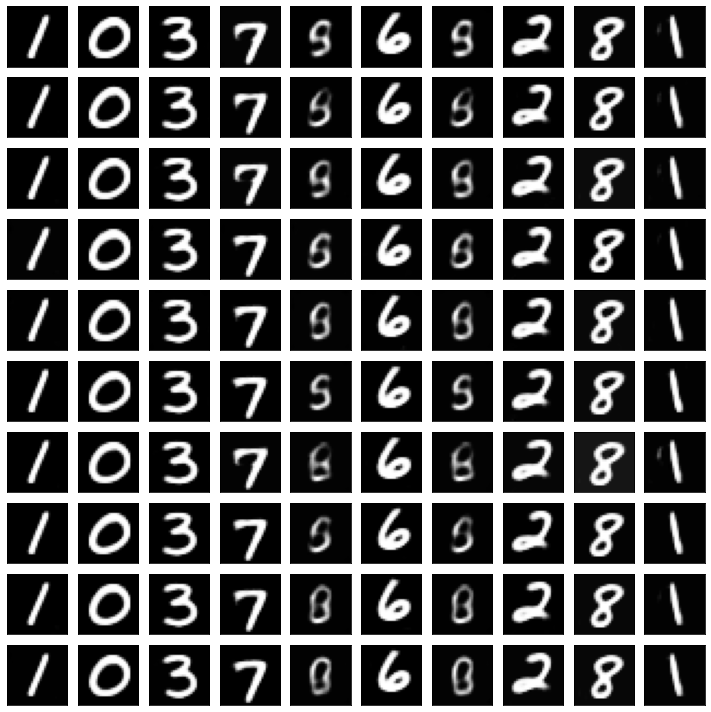

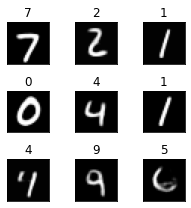

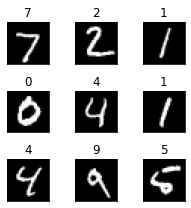

468/468 [==============================] - 11s 23ms/step - loss: 0.0703
[0.01 0.62 0.06 0.01 0.   0.08 0.   0.11 0.07 0.04]
[0.61 0.   0.   0.01 0.   0.   0.   0.04 0.01 0.32]
[0.21 0.03 0.13 0.02 0.   0.07 0.   0.42 0.04 0.07]
[0.1  0.03 0.54 0.02 0.   0.02 0.   0.09 0.09 0.11]
[0.11 0.02 0.02 0.43 0.   0.12 0.   0.07 0.04 0.18]
[0.1  0.19 0.25 0.04 0.   0.04 0.   0.07 0.2  0.13]
[0.05 0.11 0.06 0.01 0.   0.57 0.   0.04 0.03 0.11]
[0.17 0.04 0.01 0.54 0.   0.   0.   0.13 0.02 0.09]
[0.12 0.02 0.2  0.05 0.   0.03 0.   0.07 0.43 0.07]
[0.08 0.04 0.05 0.45 0.   0.04 0.   0.05 0.15 0.15]
Generate


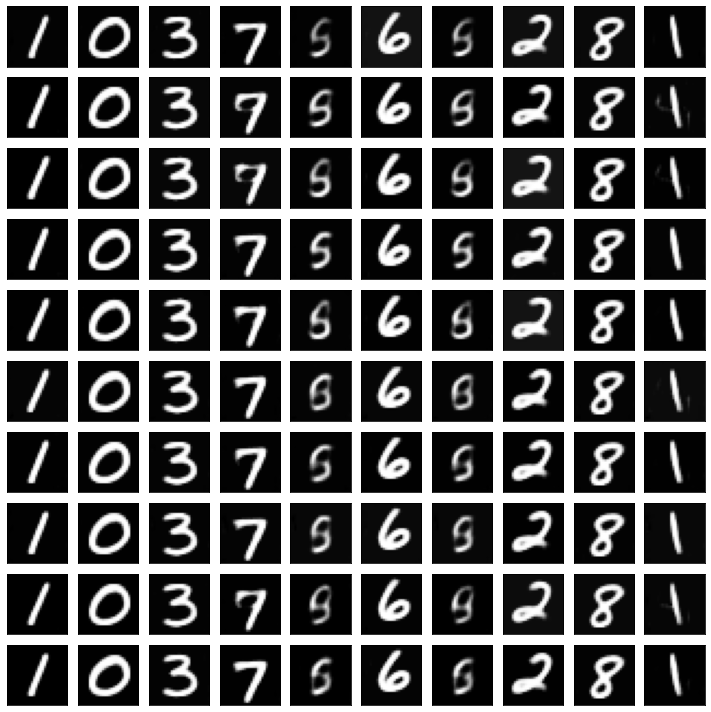

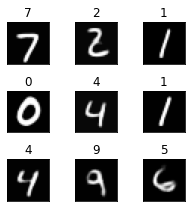

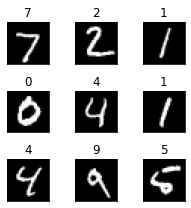

468/468 [==============================] - 11s 23ms/step - loss: 0.0671
[0.   0.58 0.06 0.01 0.   0.13 0.   0.09 0.08 0.04]
[0.63 0.   0.   0.   0.   0.01 0.   0.04 0.01 0.31]
[0.21 0.03 0.11 0.02 0.   0.09 0.   0.42 0.04 0.07]
[0.1  0.02 0.57 0.02 0.   0.03 0.   0.08 0.08 0.1 ]
[0.12 0.02 0.01 0.38 0.   0.14 0.   0.07 0.04 0.22]
[0.11 0.16 0.28 0.04 0.   0.06 0.   0.06 0.19 0.11]
[0.05 0.07 0.04 0.01 0.   0.67 0.   0.03 0.04 0.1 ]
[0.18 0.04 0.01 0.53 0.   0.01 0.   0.13 0.02 0.09]
[0.12 0.02 0.18 0.05 0.   0.05 0.   0.06 0.44 0.07]
[0.08 0.03 0.04 0.43 0.   0.05 0.   0.05 0.14 0.18]
Generate


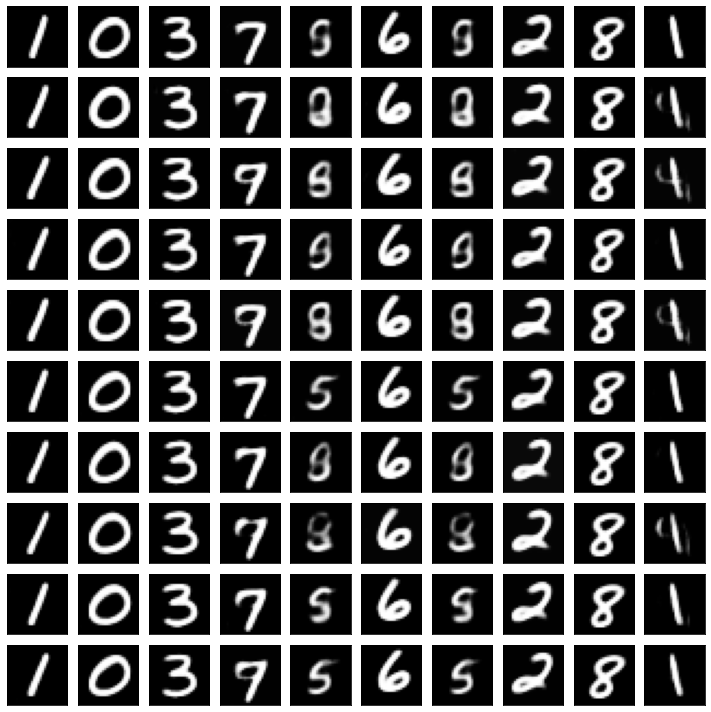

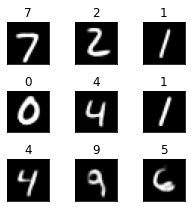

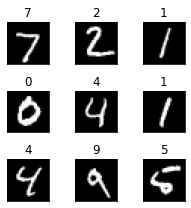

468/468 [==============================] - 11s 23ms/step - loss: 0.0640
[0.   0.62 0.06 0.01 0.   0.09 0.   0.1  0.08 0.03]
[0.64 0.   0.   0.   0.   0.   0.   0.05 0.01 0.29]
[0.22 0.03 0.1  0.02 0.   0.07 0.   0.45 0.04 0.07]
[0.12 0.02 0.54 0.02 0.   0.02 0.   0.08 0.1  0.1 ]
[0.11 0.03 0.01 0.42 0.   0.1  0.   0.08 0.03 0.22]
[0.11 0.18 0.26 0.03 0.   0.04 0.   0.06 0.2  0.11]
[0.05 0.11 0.05 0.01 0.   0.59 0.   0.04 0.04 0.13]
[0.15 0.04 0.01 0.53 0.   0.   0.   0.15 0.01 0.09]
[0.13 0.02 0.15 0.04 0.   0.04 0.   0.06 0.46 0.08]
[0.08 0.04 0.03 0.44 0.   0.03 0.   0.06 0.13 0.18]
Generate


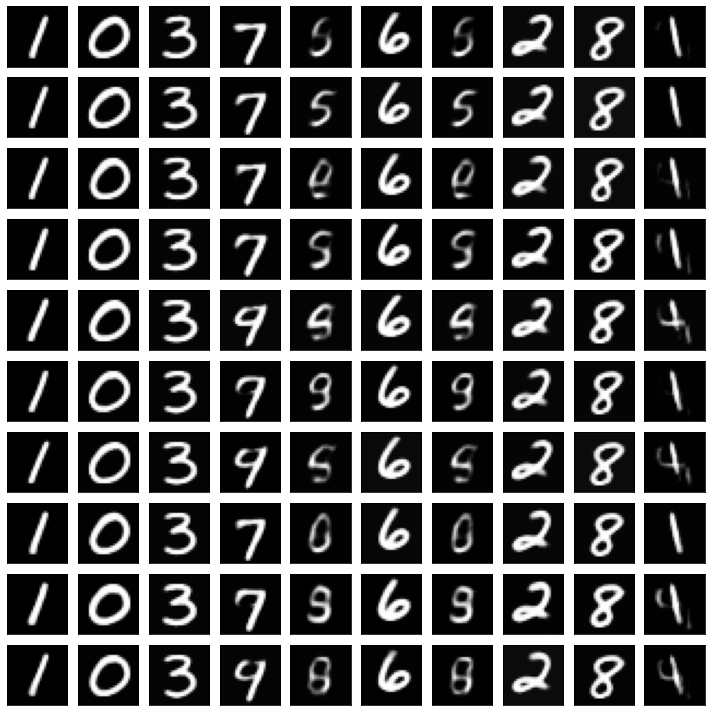

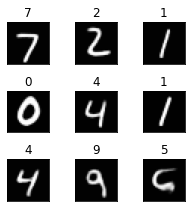

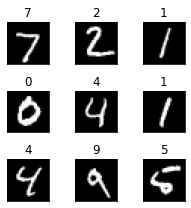

468/468 [==============================] - 11s 23ms/step - loss: 0.0614
[0.   0.65 0.07 0.01 0.   0.1  0.   0.08 0.06 0.03]
[0.65 0.   0.   0.   0.   0.   0.   0.06 0.01 0.27]
[0.2  0.04 0.12 0.02 0.   0.08 0.   0.44 0.04 0.06]
[0.12 0.02 0.55 0.02 0.   0.02 0.   0.08 0.09 0.09]
[0.13 0.03 0.01 0.41 0.   0.1  0.   0.07 0.03 0.23]
[0.11 0.2  0.28 0.03 0.   0.04 0.   0.07 0.16 0.11]
[0.05 0.09 0.06 0.01 0.   0.61 0.   0.04 0.03 0.1 ]
[0.16 0.05 0.01 0.53 0.   0.   0.   0.13 0.01 0.1 ]
[0.13 0.03 0.17 0.05 0.   0.04 0.   0.07 0.44 0.07]
[0.09 0.05 0.03 0.45 0.   0.04 0.   0.05 0.1  0.2 ]
Generate


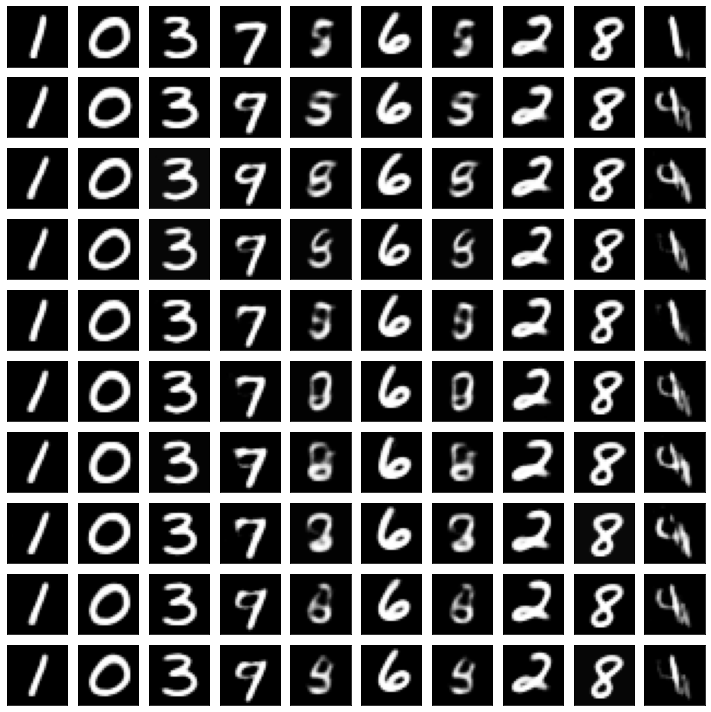

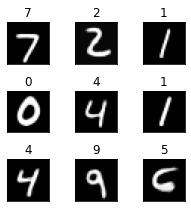

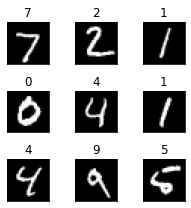

468/468 [==============================] - 11s 23ms/step - loss: 0.0589
[0.   0.63 0.05 0.01 0.   0.12 0.   0.09 0.07 0.03]
[0.64 0.   0.   0.   0.   0.01 0.   0.06 0.01 0.28]
[0.2  0.03 0.11 0.02 0.   0.07 0.   0.48 0.04 0.05]
[0.11 0.02 0.59 0.02 0.   0.02 0.   0.09 0.09 0.07]
[0.11 0.03 0.01 0.43 0.   0.12 0.   0.07 0.03 0.2 ]
[0.11 0.18 0.28 0.04 0.   0.05 0.   0.07 0.19 0.09]
[0.05 0.08 0.05 0.01 0.   0.67 0.   0.04 0.03 0.08]
[0.14 0.04 0.01 0.55 0.   0.01 0.   0.15 0.01 0.09]
[0.12 0.02 0.17 0.05 0.   0.05 0.   0.07 0.46 0.06]
[0.08 0.04 0.03 0.47 0.   0.04 0.   0.05 0.11 0.19]
Generate


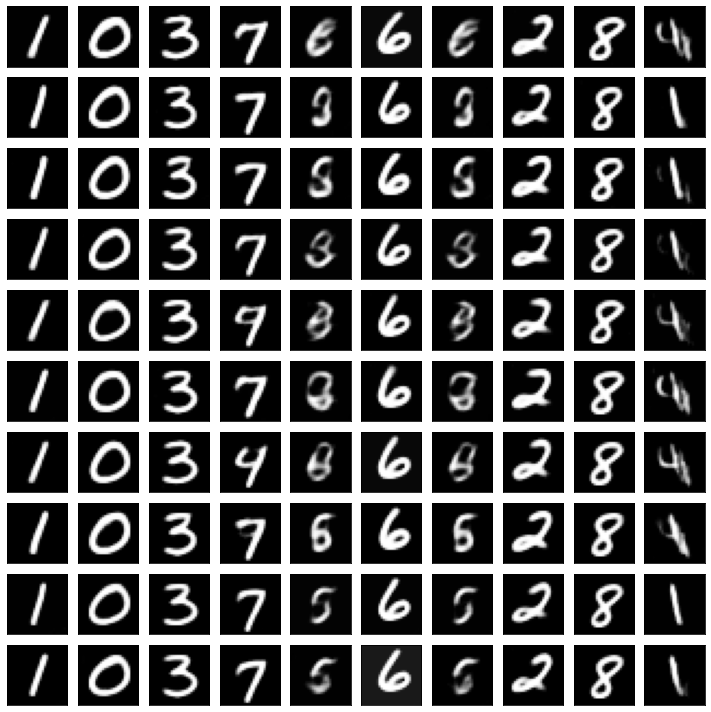

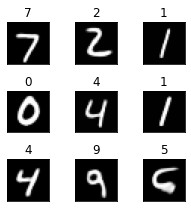

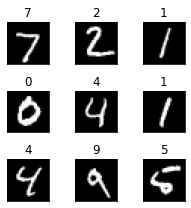

468/468 [==============================] - 11s 23ms/step - loss: 0.0566
[0.   0.63 0.07 0.01 0.   0.1  0.   0.09 0.06 0.04]
[0.68 0.   0.   0.   0.   0.   0.   0.05 0.01 0.25]
[0.23 0.04 0.1  0.01 0.   0.07 0.   0.43 0.05 0.07]
[0.14 0.02 0.54 0.02 0.   0.02 0.   0.08 0.1  0.09]
[0.13 0.02 0.01 0.41 0.   0.09 0.   0.07 0.02 0.24]
[0.11 0.16 0.28 0.04 0.   0.04 0.   0.06 0.2  0.1 ]
[0.05 0.08 0.06 0.01 0.   0.62 0.   0.04 0.04 0.11]
[0.16 0.04 0.01 0.54 0.   0.01 0.   0.14 0.01 0.1 ]
[0.14 0.02 0.16 0.04 0.   0.04 0.   0.06 0.47 0.07]
[0.09 0.04 0.02 0.46 0.   0.03 0.   0.05 0.1  0.21]
Generate


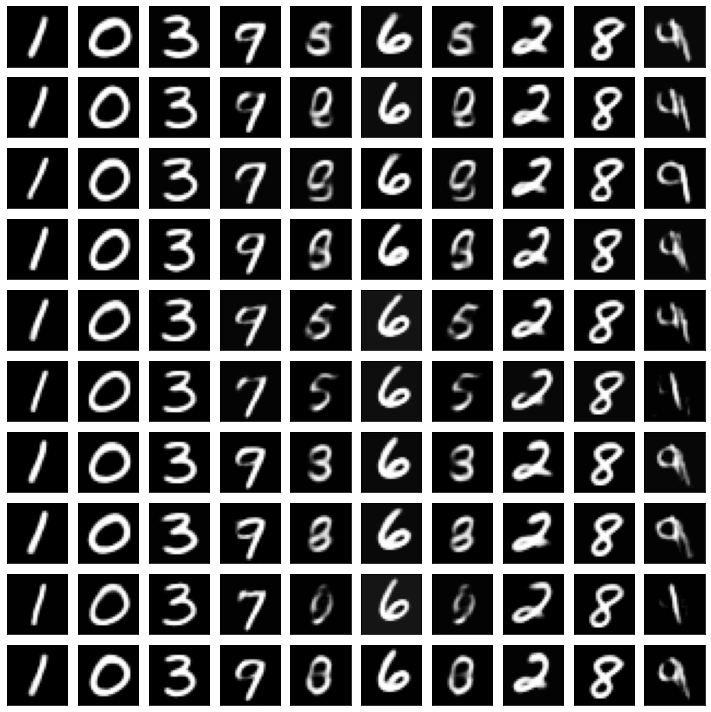

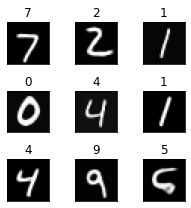

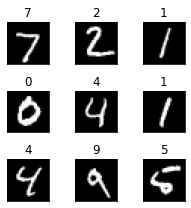

In [0]:
@noargs
def generate_conditional():
    print("Generate")
    cluster_idx = np.array(list(range(10)))
    clusters = np.eye(10)[cluster_idx]
    samples = []
    for _ in range(10):
        z = np.random.uniform(low=-1, high=1, size=32)
        z = np.array([z]*10)
        generated = decoder.predict([z, clusters])
        samples += [generated]
    samples = np.concatenate(samples, axis=0)
    visualize_digits(samples)


classes = [
    x_test[y_test==i] for i in range(10)
]
@noargs
def confusion_matrix():
    for i in range(10):
        _, clusters = encoder.predict([classes[i], np.zeros([len(classes[i]), 1])])
        print(clusters.mean(0).round(2))

training = Schedule().every(1).do(
    lambda step, d: autoencoder.fit(batches(x_train, 120/(step*2+15)))
).every(5, 0).do(
    confusion_matrix
).every(5, 0).do(
    generate_conditional
).every(5, 0).do(
    show_samples
)
    
training.forNext(51).execute()